In [38]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor
import sympy 
import pandas as pd

In [39]:

# Carga los archivos .xlsx
file1 = '../DataExperiments/WT_in_LB_data_s1.XLSX'
file2 = '../DataExperiments/different_conditions_data_s2.XLSX'

# Lee las hojas de los archivos
df1 = pd.read_excel(file1, engine='openpyxl')  # Especifica la hoja si es necesario: sheet_name='nombre_hoja'
df2 = pd.read_excel(file2, engine='openpyxl')

# Cambiar la fila 0 a la nueva cabecera
df2.columns = df2.iloc[0]  # Establecer la primera fila como nueva cabecera
df2 = df2[1:]  # Eliminar la primera fila

# Reiniciar los índices (opcional, si quieres que empiece desde 0)
df2 = df2.reset_index(drop=True)

# Muestra los DataFrames
print("Archivo 1:")
display(df1)

print("Archivo 2:")
display(df2)


Archivo 1:


,Cycle Nr.,Time [s],Temp. [°C],G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,1,0.0,30.8,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,2,678.6,30.7,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,3,1357.1,30.4,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,4,2035.7,30.2,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,5,2714.2,30.0,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,335199.8,30.8,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,496,335878.3,30.9,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,497,336556.8,30.8,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,498,337235.3,30.8,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


Archivo 2:


,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11
0,1,0,30,0.0929,0.0971,0.0948,0.0961,0.0939,0.0934,0.0938,...,0.0913,0.0914,0.0924,0.0916,0.0925,0.0921,0.092,0.093,0.0927,0.093
1,2,678.6,30.5,0.0925,0.0962,0.0946,0.0953,0.0935,0.0931,0.0933,...,0.0913,0.0916,0.0926,0.092,0.0914,0.0921,0.0921,0.0931,0.0932,0.0925
2,3,1357.2,30.1,0.0926,0.0962,0.095,0.0954,0.0936,0.0932,0.0932,...,0.0916,0.0917,0.0927,0.0918,0.0917,0.0922,0.0923,0.0932,0.0932,0.0927
3,4,2035.8,30,0.0928,0.0981,0.0949,0.0956,0.0937,0.0934,0.0934,...,0.092,0.0921,0.0931,0.0922,0.0922,0.0928,0.0926,0.0936,0.0937,0.093
4,5,2714.4,30.3,0.0933,0.0985,0.0953,0.096,0.0942,0.0939,0.0938,...,0.0925,0.0927,0.0937,0.0928,0.093,0.0933,0.0933,0.0943,0.0944,0.0938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,228685.2,29.9,0.5954,0.6453,0.6513,0.6593,0.6599,0.6576,0.5901,...,0.0926,0.0926,0.0935,0.0924,0.0949,1.0018,0.9769,0.9848,0.9871,0.9972
338,339,229363.7,29.8,0.5937,0.6448,0.6495,0.6568,0.6572,0.6564,0.5898,...,0.0926,0.0927,0.0934,0.0926,0.0953,1.0017,0.98,0.9857,0.9868,0.9976
339,340,230042.3,29.9,0.5923,0.6429,0.6487,0.6575,0.6589,0.6572,0.5889,...,0.0925,0.0925,0.0933,0.0923,0.0947,1.0009,0.9758,0.9833,0.9846,0.9963
340,341,230720.9,30.3,0.5912,0.6419,0.6484,0.6568,0.657,0.6548,0.5888,...,0.0923,0.0924,0.0932,0.0921,0.0942,1.0004,0.9763,0.9843,0.9845,0.9981


In [40]:
df2.iloc[:, 9:15]


,A7,A8,A9,A10,A11,A12
0,0.0938,0.0933,0.0947,0.094,0.0945,0.0923
1,0.0933,0.0932,0.0948,0.0937,0.0937,0.0923
2,0.0932,0.0933,0.0948,0.0939,0.0939,0.0927
3,0.0934,0.0935,0.095,0.0941,0.0941,0.0926
4,0.0938,0.0939,0.0954,0.0945,0.0945,0.0929
...,...,...,...,...,...,...
337,0.5901,0.6007,0.5678,0.5227,0.5631,0.308
338,0.5898,0.6002,0.5683,0.5222,0.5616,0.3055
339,0.5889,0.5999,0.5681,0.5221,0.5621,0.3051
340,0.5888,0.5992,0.5675,0.5211,0.561,0.3032


In [41]:
c=-1
P_exp=np.array(df2.iloc[:, 3:9])[:c]
T_exp=np.array(df2['Time [s]'])[:c]

T_max=max(T_exp)
T_exp=T_exp/max(T_exp)
N_exp=P_exp.shape[1]
N_exp,T_max

(6, 230720.9)

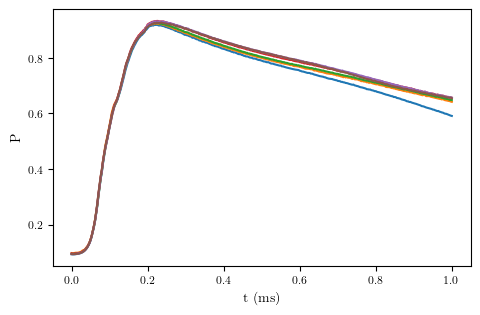

In [42]:
for i in range(N_exp):
    plt.plot(T_exp,P_exp[:, i])
plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

In [43]:
N_f = 1000 # Number of residual point
N_d = 500 #Number of data

P_star = P_exp.T.flatten().reshape([-1,1])
P0=P_exp[0,:]
T_meshgrid, P0_meshgrid, = np.meshgrid(T_exp, P0)
X_star = np.hstack((T_meshgrid.flatten()[:,None], P0_meshgrid.flatten()[:,None]))
u_star=np.hstack((P_star,P0_meshgrid.flatten()[:,None]))


# T_star = np.tile(T_exp,N_exp).reshape([-1,1])

# Doman bounds
lb = X_star.min(0)
lb[1]=lb[1]
ub = X_star.max(0) 
ub[1]=ub[1]


# Initial Condition
xx0 = X_star[::len(T_exp)]
uu0 = P_star[::len(T_exp)]

xx1= np.hstack((np.ones(len(P0)).reshape([-1,1]), P0.reshape([-1,1])))

xx01=np.vstack((xx0, xx1))
uu01=np.array([1]*N_exp+[0]*N_exp).reshape([-1,1])

# Additional data
idx = np.random.choice(P_star.shape[0], N_d-len(uu0), replace=False)
xxd = X_star[idx]
uud = P_star[idx]

X_u_train = np.concatenate((xx0,xxd))
P_train = np.concatenate((uu0,uud))

X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))

X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
P_train_tf =   tf.convert_to_tensor(P_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
P_star_tf = tf.convert_to_tensor(P_star, dtype=tf.float32)
xx01_tf = tf.convert_to_tensor(xx01, dtype=tf.float32)
uu01_tf = tf.convert_to_tensor(uu01, dtype=tf.float32)

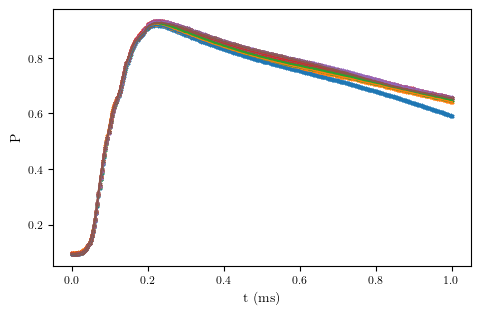

In [44]:
L_exp=len(P_exp[:,1])
for i in range(N_exp):
    plt.plot(X_star[L_exp*i:L_exp*(i+1)][:,0],P_exp[:, i])
    plt.scatter(X_star[L_exp*i:L_exp*(i+1)][:,0],P_star[L_exp*i:L_exp*(i+1)], marker='x', s=5)

plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

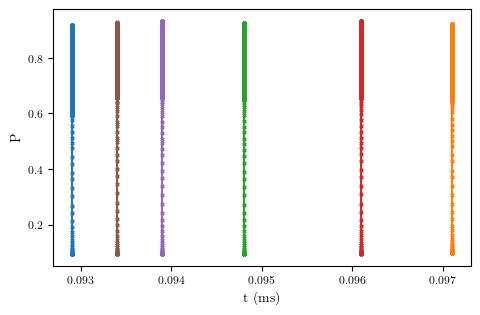

In [45]:
L_exp=len(P_exp[:,1])
for i in range(N_exp):
    plt.plot(X_star[L_exp*i:L_exp*(i+1)][:,1],P_exp[:, i])
    plt.scatter(X_star[L_exp*i:L_exp*(i+1)][:,1],P_star[L_exp*i:L_exp*(i+1)], marker='x', s=5)

plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

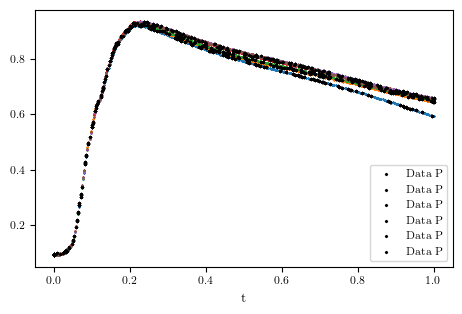

In [46]:
L_exp=len(P_exp[:,1])
for i in range(N_exp):
    plt.scatter(X_star[L_exp*i:L_exp*(i+1)][:,0],P_star[L_exp*i:L_exp*(i+1)], marker='x', s=1)
    plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# #plt.savefig('figures/P_phi.pdf')
plt.show()

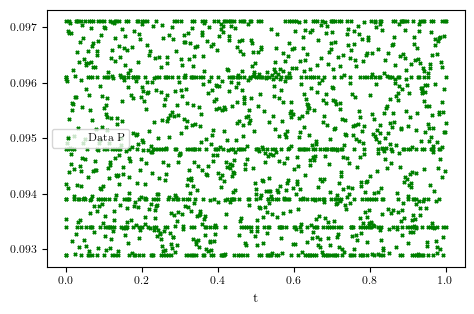

In [47]:

plt.scatter(X_f_train_tf[:,0], X_f_train_tf[:,1], s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# #plt.savefig('figures/P_phi.pdf')
plt.show()

In [48]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 


def net(t, w, b):
    p = DNN(t, w, b)
    return p

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r, 2]), dtype=tf.float32)
    alpha_0 = tf.Variable(tf.reshape(tf.repeat(1000.0, N_exp*2), (N_exp*2, -1))) 
    return alpha_r, alpha_b, alpha_0


#@tf.function(jit_compile=True)
@tf.function()
def net_f(X_f, W_p, b_p, W_phi, b_phi, lnv):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([X_f])
        u=net(X_f, W_p, b_p)

        p=tf.exp(u)
        t=X_f[...,0:1]


        phi=net(tf.concat([p, t],1), W_phi, b_phi)


    p_t = tape1.gradient(p, X_f)[...,0:1]
    # s_t = tape1.gradient(s, X_f)[...,0:1]

    f_p = p_t - phi*p 
    # f_s = s_t + m*p*s
    
    return f_p




#@tf.function()
@tf.function()
def train_step(W_p, b_p,  W_phi, b_phi,  X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, opt):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, W_phi, b_phi, lambda_b, lambda_r, lambda_0, lnv])
        u_nn = net(X_u_train_tf, W_p, b_p) 
        lnp=u_nn[:,0:1]
        p_nn=tf.exp(lnp)
        f_p = net_f(X_f_train_tf, W_p, b_p, W_phi, b_phi, lnv)




        loss_p = tf.square(lambda_b*(p_nn - P_train_tf))
        # loss_0s = tf.square(lambda_0*(s_00 - uu01_tf))
        loss_fp = tf.square(lambda_r[0:1]*f_p) 
        # loss_fs = tf.square(lambda_r[1:2]*f_s) 


        loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_fp)
        
    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_phi = tape.gradient(loss, train_vars(W_phi, b_phi))
    # grads_lnv = tape.gradient(loss, lnv)
    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    # grads_0 = tape.gradient(loss, lambda_0)


    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip(grads_phi, train_vars(W_phi, b_phi)))
    # opt.apply_gradients(zip([grads_lnv], [lnv]))
    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
    # opt.apply_gradients(zip([-grads_0], [lambda_0]))

   
    return loss, tf.reduce_mean(tf.square((p_nn - P_train_tf))), tf.reduce_mean(tf.square(f_p))


layers = [2, 20, 20, 1]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

layers = [2, 20, 20, 1]


W_phi = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

lnv = tf.Variable(tf.reshape(tf.repeat(1.0, 2), (2, -1)), dtype=tf.float32) 
lambda_r, lambda_b, lambda_0 = loss_weight(N_f, N_d)



In [49]:
lr = 2e-3
# Nmax = 15000
# Nmax = 150000
Nmax=3*10**5
# Nmax=20000



optimizer = tf.optimizers.Adam(learning_rate=lr)
optimizer2 = tf.optimizers.Adam(learning_rate=lr/10)
# optimizer3 = tf.optimizers.Adam(learning_rate=lr/100)
# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
optimizer3 = tf.optimizers.Adam(learning_rate=lr/50)

# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9, clipnorm=10.0)


start_time = time.time()
n=0
loss = []
loss_d = []
loss_fisp = []
loss_fiss = []
loss_reg=[]
# loss_fisa = []

# Make a new Function and ConcreteFunction for each optimizer.
train_step_1 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_0, lnv, optimizer)
train_step_2 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, optimizer)
train_step_3 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, optimizer)


In [50]:
Nmax=2*10**5


while n <= Nmax:
    if n<10**5:
        loss_, loss_p, loss_fp = train_step_1(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv)
    elif n< 2*10**5:
        loss_, loss_p, loss_fp = train_step_2(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv)
    else:
        loss_, loss_p, loss_fp = train_step_3(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv)

    loss.append(loss_)
    loss_d.append(loss_p)
    loss_fisp.append(loss_fp)
    # loss_fiss.append(loss_fs)
    # loss_fisa.append(loss_fa)



    if n % 10 == 0:

        print(f"Iteration is: {n}")
        print(f"Total loss is: {loss_}")
        print(f"Data loss is: {loss_p}")
        print(f"Physicial loss of p is: {loss_fp}")
        # print(f"Physicial loss of s is: {loss_fs}")
        # if n%10000 ==0:
        #     loss_reg_=eval(W_p, b_p, W_phi_s, b_phi_s)
        #     loss_reg.append(loss_reg_)
        # print(f"Physicial loss of a is: {loss_fa}")

    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0
Total loss is: 768430.5625
Data loss is: 0.7684284448623657
Physicial loss of p is: 2.0537455081939697
Iteration is: 10
Total loss is: 119183.28125
Data loss is: 0.11917906254529953
Physicial loss of p is: 0.015825871378183365
Iteration is: 20
Total loss is: 36683.73828125
Data loss is: 0.03668070584535599
Physicial loss of p is: 0.11122052371501923
Iteration is: 30
Total loss is: 49968.6015625
Data loss is: 0.04996294528245926
Physicial loss of p is: 0.008511082269251347
Iteration is: 40
Total loss is: 44279.0234375
Data loss is: 0.04427197203040123
Physicial loss of p is: 0.012868201360106468
Iteration is: 50
Total loss is: 36616.2109375
Data loss is: 0.036608610302209854
Physicial loss of p is: 0.002681219484657049
Iteration is: 60
Total loss is: 35137.02734375
Data loss is: 0.03512841835618019
Physicial loss of p is: 0.0033972447272390127
Iteration is: 70
Total loss is: 35325.23046875
Data loss is: 0.03531530126929283
Physicial loss of p is: 0.0017744067590683699
It

KeyboardInterrupt: 

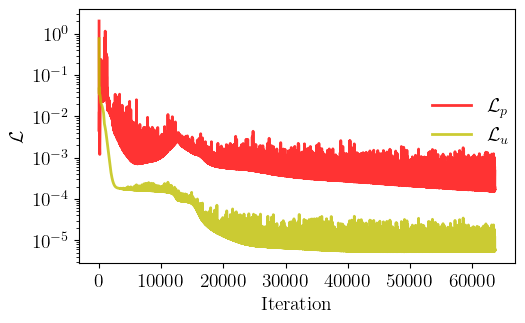

In [53]:
Nmax=len(loss)
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_data_list = [loss_d[i].numpy() for i in range(0,Nmax)]

loss_phip_list = [loss_fisp[i].numpy() for i in range(0,Nmax)]
# loss_phis_list = [loss_fiss[i].numpy() for i in range(0,Nmax)]



plt.semilogy(it, np.asarray(loss_phip_list), 'r-', linewidth = 2, alpha=0.8,  label = '$\mathcal{L}_p$')    
# plt.semilogy(it, np.asarray(loss_phis_list), 'g-', linewidth = 2, alpha=0.8,  label = '$\mathcal{L}_s$')   
plt.semilogy(it, np.asarray(loss_data_list), 'y-', linewidth = 2, alpha=0.8, label = '$\mathcal{L}_u$')  


plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(0.77, 0.4))
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$\mathcal{L}$', fontsize=14)    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
#plt.savefig('../Img/423/Loss_split.png')
#plt.savefig('../Img/423/Loss_split.pdf')
#plt.savefig('../Img/423/Loss_split.svg')
plt.show()

In [55]:
def predict(X_star_tf, w, b):
    u_pred = net(X_star_tf, w, b)
    return u_pred

## Evaluating total function
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)    
u_pred = predict(X_star_tf, W_p, b_p)
p=tf.exp(u_pred)
t=X_star_tf[...,0:1]


phi=predict(tf.concat([p, t],1), W_phi, b_phi)


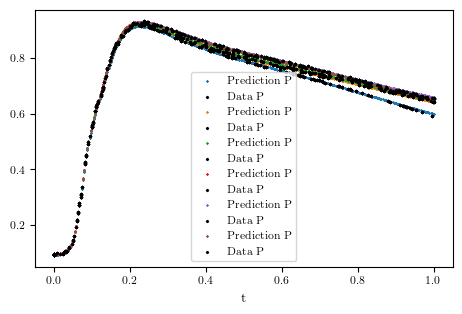

In [56]:
for i in range(N_exp):
    plt.scatter(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], marker='x', s=1,  label='Prediction P')
    plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# #plt.savefig('figures/P_phi.pdf')
plt.show()

In [57]:
# for i in range(N_exp):
#     plt.scatter(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], marker='x', s=1,  label='Prediction S')


# plt.legend()
# plt.xlabel('t')
# plt.yscale('log')
# # plt.xscale('log')

# # plt.ylabel('P')
# # #plt.savefig('figures/P_phi.pdf')
# plt.show()

In [58]:
colors = plt.cm.tab10.colors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


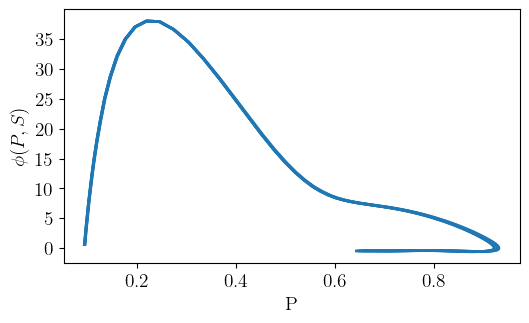

In [60]:
for i in range(1, N_exp):
    plt.plot(p[L_exp*i:L_exp*(i+1)][:,0], phi[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])
    # plt.plot(s[L_exp*i:L_exp*(i+1)][:,0], phi[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[1])

# plt.plot(p, phi,linewidth=3)
# plt.plot(s, phi, linewidth=3)
# plt.scatter(X_f_train_tf, np.zeros_like(X_f_train), marker='x', s=5, color='green',label='$f$')

# plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 0.7))
plt.legend(fontsize=14, ncols=1, frameon=False)

plt.xlabel('P', fontsize=14)
# plt.text(0.3, -0.2, r'$\mathbf{s}$', fontsize=24, color=colors[1], ha='center', transform=plt.gca().transAxes)

plt.ylabel('$\phi(P, S)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
#plt.savefig('../Img/423/Result_phi.png')
#plt.savefig('../Img/423/Result_phi.pdf')
#plt.savefig('../Img/423/Result_phi.svg')
plt.show()

In [61]:
P0, np.mean(P0)


(array([0.09290000051259995, 0.09709999710321426, 0.09480000287294388,
        0.09610000252723694, 0.09390000253915787, 0.0934000015258789],
       dtype=object),
 0.09470000118017197)

In [62]:
P0

array([0.09290000051259995, 0.09709999710321426, 0.09480000287294388,
       0.09610000252723694, 0.09390000253915787, 0.0934000015258789],
      dtype=object)

In [64]:
Nt=1000
T_int=np.zeros(Nt)
P_int=np.zeros(Nt)
# S_int=np.zeros(Nt)


dt=0.001

T_int[0]=0
P_int[0]=np.mean(P0) #Initial conditions
# P_int[0]=np.array(p[0]) #Initial conditions

# S_int[0]=np.array(s[0]) #Initial conditions




for i in range(1,Nt):

    PT=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_int[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    # PHI_S=tf.exp(net(PSA, W_a, b_a))
    
    PHI=net(PT, W_phi, b_phi)
    # REVISAAAAAR
    # PHI_S=tf.exp(predict(tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi))
    P_int[i]=P_int[i-1]+P_int[i-1]*PHI*dt
    # S_int[i]=S_int[i-1]-P_int[i-1]*S_int[i-1]*PHI_S*dt
    T_int[i]=T_int[i-1]+dt

In [24]:
l

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.4927852]], dtype=float32)>

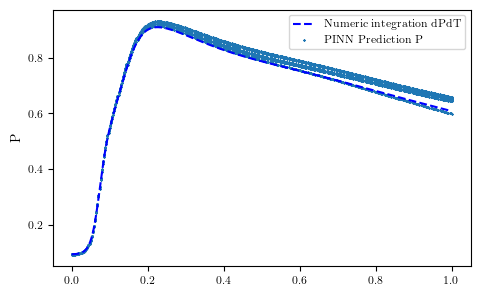

In [65]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
# plt.plot(T_int, S_int, color='orange', linestyle='--', label='Numeric integration dSdT')


plt.scatter(X_star_tf[:,0], p, marker='x', s=1,  label='PINN Prediction P')
# plt.scatter(X_star_tf[:,0], s, marker='x', s=1,  label='PINN Prediction S')
# plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

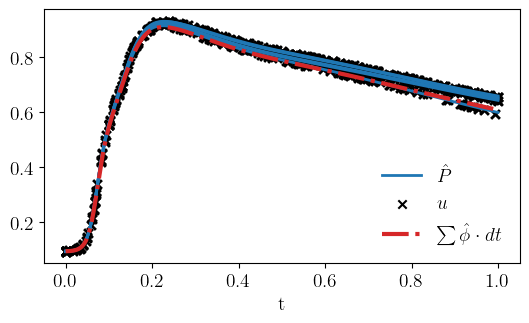

In [66]:


i=0
plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2, label='$\hat{P}$')
# plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2, label='$\hat{S}$')

plt.scatter(X_u_train[:,0], P_train, marker='x', color='black',label='$u$')
for i in range(1, N_exp):
    plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])
    # plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[1])

    plt.scatter(X_u_train[:,0], P_train, marker='x',  color='black')

plt.plot(T_int, P_int, linestyle='-.',linewidth=3, color=colors[3], label='$\sum \hat{\phi} \cdot dt$')
# plt.plot(T_int, S_int, linestyle='-.',linewidth=3, color=colors[3])
# plt.scatter(X_star_tf[:,0], p, marker='x', s=1,  label='PINN Prediction P')
# plt.legend(fontsize=12, ncols=1, frameon=False,  bbox_to_anchor=(0.7, 0.4))
plt.legend(fontsize=14, ncols=1, frameon=False)

plt.xlabel('t', fontsize=14)
# plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
#plt.savefig('../Img/423/Result_int.png')
#plt.savefig('../Img/423/Result_int.pdf')
#plt.savefig('../Img/423/Result_int.svg')
plt.show()

# Symbolic Regresion

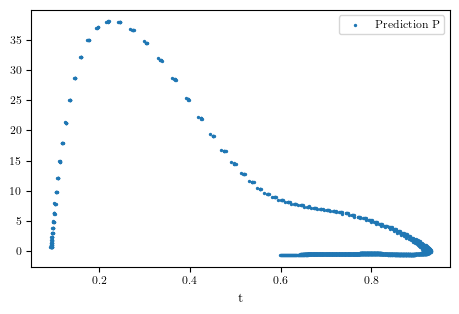

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.    , 0.0929], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9970588, 0.0934   ], dtype=float32)>)

In [67]:
c=0
d=-1
plt.scatter( p[c:d],phi[c:d], s=2, label='Prediction P')
# plt.scatter( s[c:d], np.exp(phi[c:d]), s=2, label='Prediction S')
# plt.plot( a[c:d], phi_p[c:d], label='Prediction S')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# #plt.savefig('figures/P_phi.pdf')
plt.show()
X_star_tf[c:d][0], X_star_tf[c:d][-1]

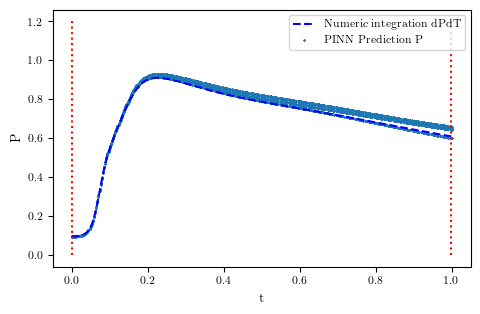

In [68]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
# plt.plot(T_int, S_int, color='orange', linestyle='--', label='Numeric integration dSdT')




plt.scatter(X_star_tf[:,0], p, marker='x', s=1,  label='PINN Prediction P')
# plt.scatter(X_star_tf[:,0], s, marker='x', s=1,  label='PINN Prediction S')


plt.vlines(X_star_tf[c:d][:,0][0],0,1.2, color='red', linestyle=':')
plt.vlines(X_star_tf[c:d][:,0][-1],0,1.2, color='red', linestyle=':')


plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

In [88]:
# Create and train the PySR model
model= PySRRegressor(
    niterations=500,
    binary_operators=["+", "*", "inv(x, y) = x/(x + y)"],
    # unary_operators=["inv(x) = 1/x"],
    # unary_operators=["exp","inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x, y: x/(x+y),},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    complexity_of_variables=1,
    complexity_of_constants=1,
    complexity_of_operators={"inv": 3},
    parsimony=0.000001,
    # select_k_features=1,
    # constraints={"constant": 0},
    maxsize=30,
    progress=True  # Show progress during training
)

In [89]:
# p1s=tf.concat([p1[c:d], s[c:d]], axis=1)

min_cols_phi= tf.math.reduce_min(phi[c:d], axis=0)
max_cols_phi= tf.math.reduce_max(phi[c:d], axis=0)

phi_scaled = (phi[c:d]-min_cols_phi)/(max_cols_phi-min_cols_phi)
PT_tf=tf.concat([p[c:d], t[c:d]],1)

model.fit( PT_tf,phi_scaled)
print(model)


c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 6.460e+04
Head worker occupation: 25.3%
Progress: 143 / 7500 total iterations (1.907%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
3           3.120e-02  5.314e+00  y = 0.24363 * 0.27089
5           1.930e-02  2.401e-01  y = -0.71186 * (-0.80943 + x₀)
7           1.761e-02  4.597e-02  y = (-0.79581 + x₁) * (-0.46097 + x₁)
9           1.523e-02  7.243e-02  y = inv(0.016548, x₁ * x₁) * 0.44576
11          1.246e-02  1.004e-01  y = -0.41799 * (-0.40244 + (-0.64078 + ((x₁ + x₀) * x₀)))
13          9.124e-03  1.559e-01  y = inv(0.06227, x₁ * ((x₀ + x₀) + -0.97651)) * 0.35333
15          1.749e-03  8.258e-01  y = inv(-0.052314 * inv(x₁ + -0.89459, x₀), x₁) * 0.15815
17          9.104e-04  3.266e-01  y = -0.011118 + (inv(-0.053883 * inv(-0.92422 + x₁, x₀), x₁) *...
                                   0.14811)
19          7.900e-04  7.088e-02  y = -0

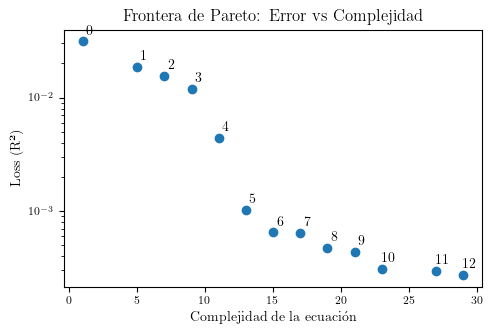

In [90]:
# Extraer las métricas de las ecuaciones
equations_df = model.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.yscale('log')
plt.show()

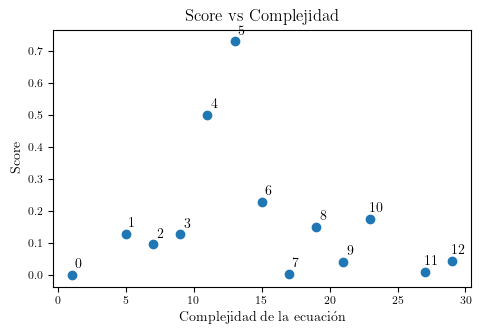

In [91]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [95]:
equations_df


,complexity,loss,score,equation,sympy_format,lambda_format
0,1,0.031200,0.000000,0.06599557,0.0659955700000000,PySRFunction(X=>0.0659955700000000)
1,5,0.018630,0.128917,(x0 * -0.58032167) + 0.48624536,0.48624536 + x0*(-0.58032167),PySRFunction(X=>0.48624536 + x0*(-0.58032167))
2,7,0.015403,0.095106,(-1.4222913 + (x1 + x0)) * -0.33267835,(x0 + x1 - 1.4222913)*(-0.33267835),PySRFunction(X=>(x0 + x1 - 1.4222913)*(-0.3326...
3,9,0.011961,0.126423,(((x0 + x1) * x0) * -0.44654453) + 0.48328194,(x0 + x1)*x0*(-0.44654453) + 0.48328194,PySRFunction(X=>(x0 + x1)*x0*(-0.44654453) + 0...
4,11,0.004405,0.499448,"inv(0.02856121, (-0.5854922 + x0) * x1) * 0.18...",(0.02856121/(x1*(x0 - 0.5854922) + 0.02856121)...,PySRFunction(X=>(0.02856121/(x1*(x0 - 0.585492...
5,13,0.001025,0.728820,"0.14208126 * inv(0.042516302, x1 * (-0.8755358...",0.14208126*(0.042516302/(x1*(x0 + x1 - 0.87553...,PySRFunction(X=>0.14208126*(0.042516302/(x1*(x...
6,15,0.000649,0.229026,"(inv(0.04578953, (-0.9262256 + (x0 + x1)) * x1...",(0.04578953/(x1*(x0 + x1 - 0.9262256) + 0.0457...,PySRFunction(X=>(0.04578953/(x1*(x0 + x1 - 0.9...
7,17,0.000643,0.004379,"(inv(0.04578953, ((x0 + (-0.9262256 + x1)) * 1...",(0.04578953/((x0 + x1 - 0.9262256)*1.0022452*x...,PySRFunction(X=>(0.04578953/((x0 + x1 - 0.9262...
8,19,0.000476,0.149849,"inv(-0.04707604 * (inv(-1.3919294 + x0, x0 + x...",x0*(-0.04707604*(x1 + (x0 - 1.3919294)/(3*x0 -...,PySRFunction(X=>x0*(-0.04707604*(x1 + (x0 - 1....
9,21,0.000440,0.039787,"(inv((inv(-1.3835671 + x0, x0 + x0) + x1) * -0...",-0.04707604*(x1 + (x0 - 1.3835671)/(3*x0 - 1.3...,PySRFunction(X=>-0.04707604*(x1 + (x0 - 1.3835...


In [96]:
for i in range(len(equations_df)):
    print(i, sympy.simplify(model.sympy(i))*(max_cols_phi-min_cols_phi)+min_cols_phi)

0 1.91446508248798
1 18.1669360460512 - 22.44298823136*x0
2 -12.865789233544*x0 - 12.865789233544*x1 + 17.6610948114336
3 -17.2693768812186*x0*(x0 + x1) + 18.0523306407687
4 -0.637805283069611 + 0.208288277384165/(x1*(x0 - 0.5854922) + 0.02856121)
5 -0.637805283069611 + 0.233616857014612/(x1*(x0 + x1 - 0.87553585) + 0.042516302)
6 38.6733589172363*(-0.02141161*x1*(x0 + x1 - 0.9262256) + 0.0053155320795907)/(x1*(x0 + x1 - 0.9262256) + 0.04578953) - 0.637805283069611
7 38.6733589172363*(-0.0215097635349256*x1*(x0 + x1 - 0.9262256) + 0.00531324406835566)/(1.0022452*x1*(x0 + x1 - 0.9262256) + 0.04578953) - 0.637805283069611
8 38.6733589172363*x0*(-0.04707604*x0 - 0.04707604*x1*(3*x0 - 1.3919294) + 0.065526524111576)/(-0.04707604*x0 + 0.95292396*x1*(3*x0 - 1.3919294) + 0.065526524111576) - 0.637805283069611
9 38.6733589172363*x0*(-0.147910992269964*x0*x1 - 0.049303664089988*x0 + 0.0682149275443588*x1 + 0.0682149275443588)/(2.85877188*x0*x1 - 0.04707604*x0 - 1.31843423985772*x1 + 0.065132860

In [97]:
for i in range(len(equations_df)):
    print(i, sympy.expand(model.sympy(i))*(max_cols_phi-min_cols_phi)+min_cols_phi)

0 1.91446508248798
1 18.1669360460512 - 22.44298823136*x0
2 -12.865789233544*x0 - 12.865789233544*x1 + 17.6610948114336
3 -17.2693768812186*x0**2 - 17.2693768812186*x0*x1 + 18.0523306407687
4 -0.637805283069611 + 0.208288277384165/(x0*x1 - 0.5854922*x1 + 0.02856121)
5 -0.637805283069611 + 0.233616857014612/(x0*x1 + x1**2 - 0.87553585*x1 + 0.042516302)
6 -1.4658641615955 + 0.243485906810122/(x0*x1 + x1**2 - 0.9262256*x1 + 0.04578953)
7 -1.46779659199387 + 0.243485906810122/(1.0022452*x0*x1 + 1.0022452*x1**2 - 0.92830516171712*x1 + 0.04578953)
8 -1.82058859132217*x0**2/(-0.14122812*x0**2/(3*x0 - 1.3919294) + 2.85877188*x0*x1 + 0.262106096446304*x0/(3*x0 - 1.3919294) - 1.32640287588842*x1 - 0.0912082953907115/(3*x0 - 1.3919294)) - 1.82058859132217*x0*x1/(-0.04707604*x0/(3*x0 - 1.3919294) + 0.95292396*x1 + 0.065526524111576/(3*x0 - 1.3919294)) + 2.53413078556592*x0/(-0.14122812*x0**2/(3*x0 - 1.3919294) + 2.85877188*x0*x1 + 0.262106096446304*x0/(3*x0 - 1.3919294) - 1.32640287588842*x1 - 0.0

In [98]:
for i in range(len(equations_df)):
    print(i, sympy.factor(model.sympy(i))*(max_cols_phi-min_cols_phi)+min_cols_phi)

0 1.91446508248798
1 18.1669360460512 - 22.44298823136*x0
2 -12.865789233544*x0 - 12.865789233544*x1 + 17.6610948114336
3 -17.2693768812186*x0**2 - 17.2693768812186*x0*x1 + 18.0523306407687
4 -0.637805283069611 + 0.208288277384165/(1.0*x0*x1 - 0.5854922*x1 + 0.02856121)
5 -0.637805283069611 + 0.233616857014612/(1.0*x0*x1 + 1.0*x1**2 - 0.87553585*x1 + 0.042516302)
6 -0.637805283069611 - 0.828058878525887*(1.0*x0*x1 + 1.0*x1**2 - 0.9262256*x1 - 0.248254665557177)/(1.0*x0*x1 + 1.0*x1**2 - 0.9262256*x1 + 0.04578953)
7 -0.829991308924263*(1.0*x0*x1 + 1.0*x1**2 - 0.9262256*x1 - 0.247015456944866)/(1.0*x0*x1 + 1.0*x1**2 - 0.9262256*x1 + 0.0456869536516613) - 0.637805283069611
8 -1.91052871765568*x0*(1.0*x0*x1 + 0.333333333333333*x0 - 0.463976466666667*x1 - 0.463976466666667)/(1.0*x0*x1 - 0.0164672250798829*x0 - 0.463976466666667*x1 + 0.0229212147251064) - 0.637805283069611
9 -2.00093436341653*x0*(1.0*x0*x1 + 0.333333333333333*x0 - 0.461189033333333*x1 - 0.461189033333333)/(1.0*x0*x1 - 0.01646

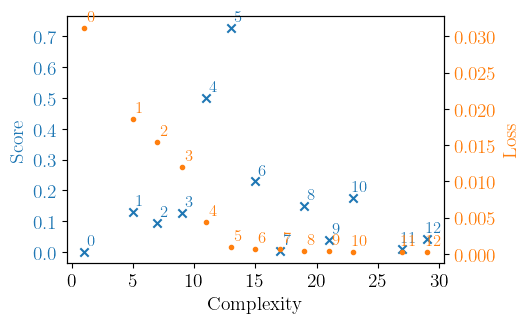

In [99]:
import matplotlib.pyplot as plt

# Obtener los colores de la paleta tab10
colors = plt.get_cmap('tab10').colors

# Crear la figura y el primer eje (izquierdo)
fig, ax1 = plt.subplots()

# Graficar score vs complejidad en el eje izquierdo usando el color tab10[0]
ax1.scatter(complejidades, scores, color=colors[0], marker='x', label='Score')
ax1.set_xlabel('Complexity', fontsize=14)
ax1.set_ylabel('Score', fontsize=14, color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])

# Añadir etiquetas de índice en cada punto para score
for i, (x, y) in enumerate(zip(complejidades, scores)):
    ax1.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color=colors[0])

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

# Crear un segundo eje (derecho) que comparte el eje x
ax2 = ax1.twinx()

# Graficar errores vs complejidad en el eje derecho usando el color tab10[1]
ax2.scatter(complejidades, errores, color=colors[1], s=9, marker='o', label='Loss')
ax2.set_ylabel('Loss', fontsize=14, color=colors[1])
ax2.tick_params(axis='y', labelcolor=colors[1])

# Añadir etiquetas de índice en cada punto para errores
for i, (x, y) in enumerate(zip(complejidades, errores)):
    ax2.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color=colors[1])

# Ajustar el gráfico para que no se corten los elementos
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
#plt.savefig('../Img/423/Score_Loss_Complexity.png')
#plt.savefig('../Img/423/Score_Loss_Complexity.pdf')
#plt.savefig('../Img/423/Score_Loss_Complexity.svg')
plt.show()


In [113]:
choose=2
choose_2=5
choose_3=len(equations_df)-1

exp=model.sympy(choose)*(max_cols_phi-min_cols_phi)+min_cols_phi
exp_2=model.sympy(choose_2)*(max_cols_phi-min_cols_phi)+min_cols_phi
exp_3=model.sympy(choose_3)*(max_cols_phi-min_cols_phi)+min_cols_phi

In [119]:
sympy.expand(exp)

-12.865789233544*x0 - 12.865789233544*x1 + 17.6610948114336

In [120]:
sympy.expand(exp_2)

-0.637805283069611 + 0.233616857014612/(x0*x1 + x1**2 - 0.87553585*x1 + 0.042516302)

In [121]:
sympy.factor(exp_3)

-0.835988999702119*(0.581340669236007*x0**3 + 1.0*x0**2*x1 - 0.6471721318331*x0**2 + 0.762935018638851*x0*x1**2 - 0.524999497297204*x0*x1 - 0.0715835205572139*x0 + 0.6643069132305*x1**2 - 0.294156308615938*x1 + 0.0100479058835221)/((1.0*x0 + 0.106865844)*(0.548748347547242*x0*x1 - 0.0125666458297773*x0 + 1.0*x1**2 - 0.33024073397945*x1 + 0.0151253971370845))

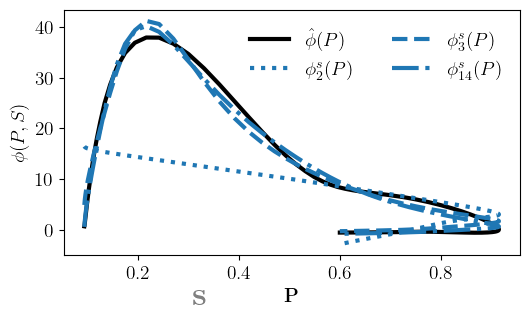

In [122]:
i=0
symb1=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
symb2=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
symb3=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi

# symb1=model_phi.predict(s,choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
# symb2=model_phi.predict(s,choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
# symb3=model_phi.predict(s,choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi


plt.plot(p[L_exp*i:L_exp*(i+1)], phi[L_exp*i:L_exp*(i+1)],linewidth=3, color='black', label='$\hat{\phi}(P)$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], phi[L_exp*i:L_exp*(i+1)],linewidth=3, color='gray', label='$\hat{\phi}(S)$')

# plt.plot(P, phi_star, linewidth=3,linestyle='--', label='$\phi^*$')
plt.plot(p[L_exp*i:L_exp*(i+1)], symb1,linewidth=3, color=colors[0], linestyle=':', label='$\phi^s_2(P)$')
plt.plot(p[L_exp*i:L_exp*(i+1)], symb2,linewidth=3, color=colors[0], linestyle='--', label='$\phi^s_{3}(P)$')
plt.plot(p[L_exp*i:L_exp*(i+1)], symb3,linewidth=3, color=colors[0],linestyle='-.', label='$\phi^s_{14}(P)$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb1,linewidth=3, color=colors[1], linestyle=':', label='$\phi^s_2(S)$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb2,linewidth=3, color=colors[1],linestyle='--', label='$\phi^s_{3}(S)$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb3,linewidth=3, color=colors[1],linestyle='-.', label='$\phi^s_{14}(S)$')



# plt.legend(fontsize=14, ncols=2, frameon=False,  bbox_to_anchor=(1, 1))
plt.legend(fontsize=14, ncols=2, frameon=False)


plt.xlabel(r'$\mathbf{P}$', fontsize=14, color='black')
plt.text(0.3, -0.2, r'$\mathbf{s}$', fontsize=24, color='gray', ha='center', transform=plt.gca().transAxes)


# plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi(P, S)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
#plt.savefig('../Img/423/Result_phi_s.png')
#plt.savefig('../Img/423/Result_phi_s.pdf')
#plt.savefig('../Img/423/Result_phi_s.svg')
plt.show()


In [118]:
Nt=10000
P_symb_1=np.zeros(Nt)
P_symb_2=np.zeros(Nt)
P_symb_3=np.zeros(Nt)
# S_symb_1=np.zeros(Nt)
# S_symb_2=np.zeros(Nt)
# S_symb_3=np.zeros(Nt)
T_symb=np.zeros(Nt)
dt=0.0001

P_symb_1[0]=P_symb_2[0]=P_symb_3[0]=np.mean(uu0) #Initial conditions
# S_symb_1[0]=S_symb_2[0]=S_symb_3[0]=np.array(tf.exp(u_pred[0,1:2])) #Initial conditions

T_symb[0]=0

for i in range(1,Nt):
    PT=tf.concat([tf.convert_to_tensor(P_symb_1[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_symb[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    PHI_S=model.predict(PT,choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
    P_symb_1[i]=P_symb_1[i-1]+(PHI_S*P_symb_1[i-1])*dt
    # S_symb_1[i]=S_symb_1[i-1]-P_symb_3[i-1]*S_symb_1[i-1]*np.array(m)*dt

    PT=tf.concat([tf.convert_to_tensor(P_symb_2[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_symb[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    PHI_S=model.predict(PT,choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
    P_symb_2[i]=P_symb_2[i-1]+(PHI_S*P_symb_2[i-1])*dt
    # S_symb_2[i]=S_symb_2[i-1]-P_symb_2[i-1]*S_symb_2[i-1]*np.array(m)*dt

    PT=tf.concat([tf.convert_to_tensor(P_symb_3[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_symb[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    PHI_S=model.predict(PT,choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
    P_symb_3[i]=P_symb_3[i-1]+(PHI_S*P_symb_3[i-1])*dt
    # S_symb_3[i]=S_symb_3[i-1]-P_symb_3[i-1]*S_symb_3[i-1]*np.array(m)*dt

    T_symb[i]=T_symb[i-1]+dt

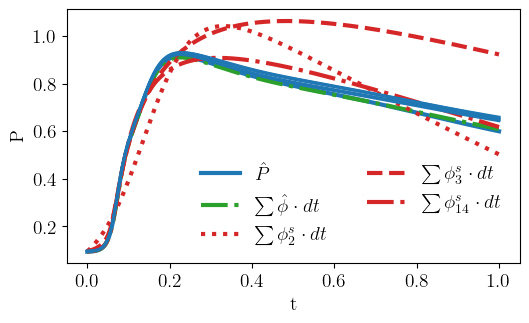

In [123]:
i=0
plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], linewidth=3, label='$\hat{P}$')
# plt.plot(T, P, linestyle='--',linewidth=3, label='$P^*$')
plt.plot(T_int, P_int, color=colors[2], linestyle='-.',linewidth=3, label='$\sum \hat{\phi} \cdot dt$')
plt.plot(T_symb, P_symb_1, color=colors[3],linestyle=':',linewidth=3, label='$\sum \phi^s_2 \cdot dt$')
plt.plot(T_symb, P_symb_2, color=colors[3],linestyle='--',linewidth=3, label='$\sum \phi^s_{3} \cdot dt$')
plt.plot(T_symb, P_symb_3, color=colors[3],linestyle='-.',linewidth=3, label='$\sum \phi^s_{14} \cdot dt$')

for i in range(1, N_exp):
    plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])
    # plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[1])

    # plt.scatter(X_u_train[:,0], P_train, marker='x',  color='black')


plt.legend(fontsize=14, ncols=2, frameon=False)
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 


plt.tight_layout()
#plt.savefig('../Img/423/Result_int_s_p.png')
#plt.savefig('../Img/423/Result_int_s_p.pdf')
#plt.savefig('../Img/423/Result_int_s_p.svg')
plt.show()

In [136]:
T_symb=np.linspace(0,1,1000)
P0=np.repeat(np.mean(P_exp[::L_exp]), len(T_symb))

In [139]:
X_star_symb=np.vstack((T_symb,P0)).T

In [141]:
X_star_symb_tf=tf.convert_to_tensor(X_star_symb, dtype=tf.float32)  
u_pred = predict(X_star_symb_tf, W_p, b_p)

# ## Evaluating unknown function
p_symb=tf.exp(u_pred)
t_symb=X_star_symb_tf[...,0:1]

# phi_s=tf.exp(net(tf.concat([p_symb, s_symb, a_symb],1), W_a, b_a))
phi=net(tf.concat([p_symb, t_symb],1), W_phi, b_phi)


In [161]:
import numpy as np
import pysindy as ps

# Supongamos que PT_tf tiene las columnas [P, T] y phi_scaled es un array
P = p_symb  # Primera columna (Presión)
T = t_symb  # Segunda columna (Temperatura)
min_cols_phi_p= tf.math.reduce_min(phi, axis=0)
max_cols_phi_p= tf.math.reduce_max(phi, axis=0)

phi_scaled = (phi-min_cols_phi_p)/(max_cols_phi_p-min_cols_phi_p)

phi_scaled = np.array(phi_scaled)[:,0] # Datos de phi_scaled

# Combinar P y T en una matriz de entrada
X = np.column_stack([P, T])


In [162]:
phi_scaled.shape

(1000,)

In [163]:
X.shape

(1000, 2)

In [208]:
# Configurar la librería de funciones
library = ps.PolynomialLibrary(degree=1)  # Hasta tercer grado polinomial


# Crear el modelo SINDy con optimizador
model = ps.SINDy(feature_library=library, optimizer=ps.STLSQ(threshold=0.1))

# Ajustar el modelo a los datos
model.fit(X, x_dot=phi_scaled)  # Aquí phi_scaled se interpreta como "derivadas" del sistema

# Imprimir la ecuación aprendida
model.print()


(x0)' = 0.564 1 + -0.523 x0 + -0.241 x1


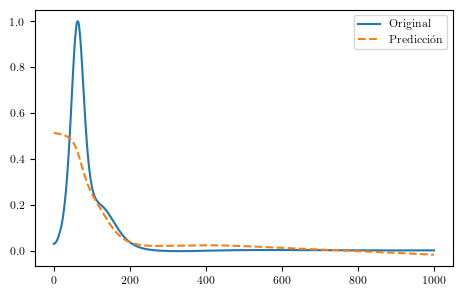

In [209]:
predicted_phi = model.predict(X)

# Comparar predicción con phi_scaled original
import matplotlib.pyplot as plt
plt.plot(phi_scaled, label="Original")
plt.plot(predicted_phi, label="Predicción", linestyle="dashed")
plt.legend()
plt.show()

In [210]:
Nt=10000
P_symb_s=np.zeros(Nt)
# S_symb_1=np.zeros(Nt)
# S_symb_2=np.zeros(Nt)
# S_symb_3=np.zeros(Nt)
T_symb=np.zeros(Nt)
dt=0.0001

P_symb_s[0]=np.mean(uu0) #Initial conditions
# S_symb_1[0]=S_symb_2[0]=S_symb_3[0]=np.array(tf.exp(u_pred[0,1:2])) #Initial conditions

T_symb[0]=0

for i in range(1,Nt):
    PT=tf.concat([tf.convert_to_tensor(P_symb_s[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_symb[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    PHI_S=model.predict(PT).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
    P_symb_s[i]=P_symb_s[i-1]+(PHI_S*P_symb_s[i-1])*dt
    T_symb[i]=T_symb[i-1]+dt

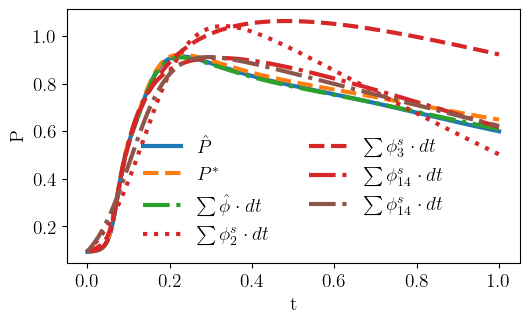

In [212]:
i=0
plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], linewidth=3, label='$\hat{P}$')
plt.plot(T, P, linestyle='--',linewidth=3, label='$P^*$')
plt.plot(T_int, P_int, color=colors[2], linestyle='-.',linewidth=3, label='$\sum \hat{\phi} \cdot dt$')
plt.plot(T_symb, P_symb_1, color=colors[3],linestyle=':',linewidth=3, label='$\sum \phi^s_2 \cdot dt$')
plt.plot(T_symb, P_symb_2, color=colors[3],linestyle='--',linewidth=3, label='$\sum \phi^s_{3} \cdot dt$')
plt.plot(T_symb, P_symb_3, color=colors[3],linestyle='-.',linewidth=3, label='$\sum \phi^s_{14} \cdot dt$')
plt.plot(T_symb, P_symb_s, color=colors[5],linestyle='-.',linewidth=3, label='$\sum \phi^s_{14} \cdot dt$')

# for i in range(1, N_exp):
#     plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])
#     # plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[1])

#     # plt.scatter(X_u_train[:,0], P_train, marker='x',  color='black')


plt.legend(fontsize=14, ncols=2, frameon=False)
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 


plt.tight_layout()
plt.savefig('../Img/423/Result_int_sindy.png')
plt.savefig('../Img/423/Result_int_sindy.pdf')
plt.savefig('../Img/423/Result_int_sindy.svg')
plt.show()

In [213]:
# i=0
# for i in range(1, N_exp):
#     plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])
#     # plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[1])

#     # plt.scatter(X_u_train[:,0], P_train, marker='x',  color='black')

# plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], linewidth=3, label='$\hat{P}$')
# # plt.plot(T, P, linestyle='--',linewidth=3, label='$P^*$')
# plt.plot(T_int, S_int, color=colors[2], linestyle='-.',linewidth=3, label='$\sum \hat{\phi} \cdot dt$')
# plt.plot(T_symb, S_symb_1, color=colors[3],linestyle=':',linewidth=3, label='$\sum \phi^s_2 \cdot dt$')
# plt.plot(T_symb, S_symb_2, color=colors[3],linestyle='--',linewidth=3, label='$\sum \phi^s_{3} \cdot dt$')
# plt.plot(T_symb, S_symb_3, color=colors[3],linestyle='-.',linewidth=3, label='$\sum \phi^s_{14} \cdot dt$')



# plt.legend(fontsize=14, ncols=2, frameon=False)
# plt.xlabel('t', fontsize=14)
# plt.ylabel('P', fontsize=14)
# plt.xticks(fontsize=14)  
# plt.yticks(fontsize=14) 


# plt.tight_layout()
# #plt.savefig('../Img/423/Result_int_s_s.png')
# #plt.savefig('../Img/423/Result_int_s_s.pdf')
# #plt.savefig('../Img/423/Result_int_s_s.svg')
# plt.show()